# Example 8: Feasible Set of an MPC problem

In [1]:
import numpy as np
import scipy.linalg as spa
import pypolycontain as pp
import pydrake.solvers.mathematicalprogram as MP
import pydrake.solvers.gurobi as Gurobi_drake
# use Gurobi solver
global gurobi_solver, license
gurobi_solver=Gurobi_drake.GurobiSolver()
license = gurobi_solver.AcquireLicense()
import pydrake.solvers.scs as SCS
scs_solver=SCS.ScsSolver()
np.random.seed(0)

In [2]:
# Triangular stack
def triangular_stack(A,B):
    q=B.shape[1]-A.shape[1]
    if q>=0:
        return np.vstack((np.hstack((A,np.zeros((A.shape[0],q)))),B))
    else:
        return np.vstack((A,np.hstack((B,np.zeros((B.shape[0],-q))))))

## Dynamics of the system

We have:
$$
x^+ = Ax + Bu
$$
Then we have:
$$
x_t = A^t x_0 + (A^{t-1}B, \cdots, AB, B) [u_0, \cdots, u_{t-1}, u_{t-1}]
$$

In [3]:
# Dynamics
delta=0.01
T=100
A=np.array([[1,delta],[-delta*2,1]])
B=np.array([[1/2*delta**2,delta]]).reshape(2,1)
phi={}
phi[1,'u']=B
phi[0]=np.eye(2)
for t in range(2,T+1):
    phi[t,'u']= np.hstack(( np.dot(A,phi[t-1,'u']) , B ))    
for t in range(1,T+1):
    At=np.linalg.matrix_power(A,t)
    phi[t]=np.hstack(( At, phi[t,'u'] ))

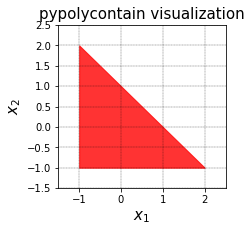

In [4]:
H=np.array([[-1,0],\
           [0,-1],\
           [1,1]]).reshape(3,2)
h=np.array([1,1,1]).reshape(3,1)
# H=np.array([[-1,0.5],\
#            [0,-1],\
#            [1,0.5],
#            [0,1]]).reshape(4,2)
# h=np.array([1,1,1,1]).reshape(4,1)
my_constraint=pp.H_polytope(H,h)
pp.visualize([my_constraint],figsize=(3,3))

In [5]:
my_H=H
for t in range(1,T+1):
    Hphi=np.dot(H,phi[t])
    my_H=triangular_stack(my_H,Hphi)
my_h=np.vstack([h]*(T+1))

u_max=1
H_control= np.hstack(( np.zeros((2*(T),2)),pp.unitbox(T).H_polytope.H ))
h_control= np.hstack(( pp.unitbox(T).H_polytope.h * u_max )).reshape((T)*2,1)

final_H=np.vstack(( my_H, H_control))
final_h=np.vstack(( my_h, h_control))
my_set=pp.H_polytope( final_H, final_h)
my_set.color='blue'

In [6]:
h_control.shape

(200, 1)

In [7]:
Pi=np.zeros(( 2,T+2 )) 
Pi[0,0],Pi[1,1]=1,1
X=pp.affine_map(T=Pi,P=my_set)
V=pp.to_V(X,10**4)

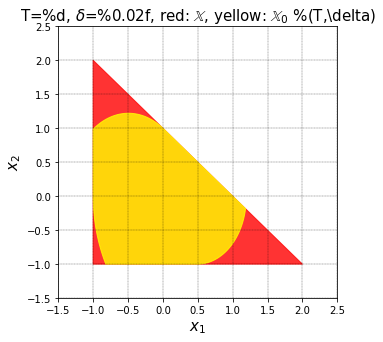

In [8]:
X.color='yellow'
pp.visualize([my_constraint,X],figsize=(5,5),title=r'T=%d, $\delta$=%0.02f, red: $\mathbb{X}$, yellow: $\mathbb{X}_0$ %(T,\delta)')

In [9]:
from cdd import Polyhedron,Matrix,RepType
V.shape

(225, 2)

(225, 2)

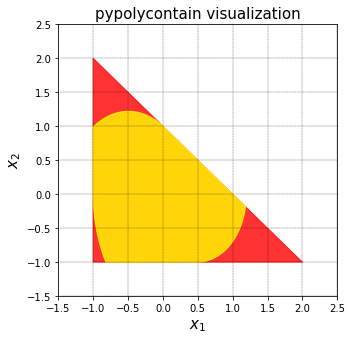

In [10]:
 p_mat=Matrix(np.hstack ((np.ones((V.shape[0],1)),V   )) )
p_mat.rep_type = RepType.GENERATOR
poly=Polyhedron(p_mat)
ineq=np.array(poly.get_inequalities())
h=np.atleast_2d(ineq[:,0]).T
H=-ineq[:,1:]
Y=pp.H_polytope(H,h,color='yellow')
pp.visualize([my_constraint,Y],figsize=(5,5))
H.shape

In [11]:
S0=pp.ray_shooting_hyperplanes(X,N=3,H_y=None,tol=0.01)

(6, 2)


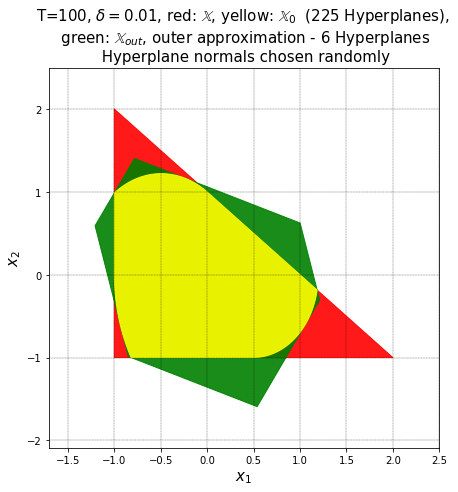

In [12]:
print(S0.H.shape)
S0.color='green'
pp.visualize([my_constraint,S0,Y],figsize=(7,7),alpha=0.9,title=\
             'T=%d, $\delta=%0.02f$, red: $\mathbb{X}$, yellow: $\mathbb{X}_{0}$  (%d Hyperplanes), \n green: $\mathbb{X}_{out}$, outer approximation - %d Hyperplanes \n Hyperplane normals chosen randomly'\
            %(T,delta,H.shape[0],S0.H.shape[0]))

###### With Necessary and Sufficient Encoding (Lossless)

In [13]:
if T<4:
    inner,volume=pp.inner_optimization(X,X=S0,N=100,k=0)
    inner.color='blue'
    pp.visualize([S0,my_constraint,Y,inner],figsize=(6,6),alpha=1,title=\
                 'T=%d, $\delta=%0.02f$, red: $\mathbb{X}$, yellow: $\mathbb{X}_0$  (%d Hyperplanes), \n blue: $\mathbb{X}_0$, inner approximation - %d Hyperplanes)'\
                %(T,delta,H.shape[0],inner.H.shape[0]))

In [14]:
if T<6:
    inner,volume=pp.inner_optimization(X,X=S0,N=100,k=1,iterations=5)
    inner.color='blue'
    pp.visualize([my_constraint,Y,inner],figsize=(7,7),alpha=0.9,title=\
             'T=%d, $\delta=%0.02f$, red: $\mathbb{X}$, yellow: $\mathbb{X}_0$  (%d Hyperplanes), \n blue: $\mathbb{X}_{in}$, inner approx. - %d Hyperplanes, Volume=$%0.02f V_o$ \n Subset Encoding with Theorem 1'\
            %(T,delta,H.shape[0],inner.H.shape[0],volume))

## With Only Sufficient Encoding (Conservative but Efficient)

Using Positive Orthant


[2021-01-18 19:33:19.110] [console] [info] SCS returns code 2, with message "SCS solved inaccurate".



success
determinent= 0.4620654718750543


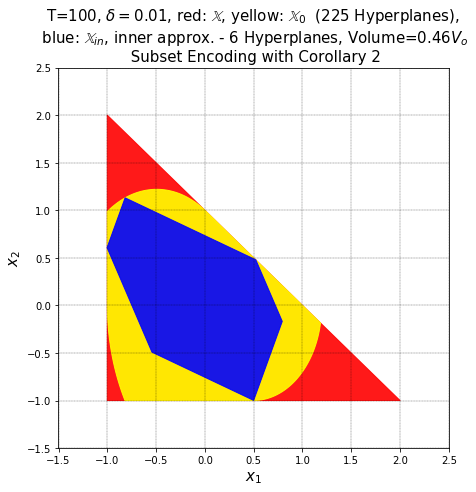

In [15]:
inner,volume=pp.inner_optimization(X,X=S0,N=100,k=-1,approach='SDP')
inner.color='blue'
pp.visualize([my_constraint,Y,inner],figsize=(7,7),alpha=0.9,title=\
         'T=%d, $\delta=%0.02f$, red: $\mathbb{X}$, yellow: $\mathbb{X}_0$  (%d Hyperplanes), \n blue: $\mathbb{X}_{in}$, inner approx. - %d Hyperplanes, Volume=$%0.02fV_o$ \n Subset Encoding with Corollary 2'\
        %(T,delta,H.shape[0],inner.H.shape[0],volume))

In [16]:
pp.Hausdorff_distance(inner,X,directed=True,k=-1)

0.4325240802019477

In [17]:
X

AH_polytope from R^102 to R^2